# Assignment7 - Generative Models

## Initialization

In [1]:
import tensorflow as tf
tf.enable_eager_execution()

import functools
import matplotlib.pyplot as plt
import numpy as np
import pdb

# Download the class repository
! git clone https://github.com/aamini/introtodeeplearning_labs.git  > /dev/null 2>&1
% cd introtodeeplearning_labs 
! git pull
% cd .. 

!cp -r introtodeeplearning_labs/lab1 lab1
!cp -r /content/lab1/util.py util.py

# Import the necessary class-specific utility files for this lab
import introtodeeplearning_labs as util

/content/introtodeeplearning_labs
Already up to date.
/content


## Dataset

In [2]:
# Get the training data: both images from CelebA and ImageNet
path_to_training_data = tf.keras.utils.get_file('train_face.h5', 'https://www.dropbox.com/s/l5iqduhe0gwxumq/train_face.h5?dl=1')
# Instantiate a TrainingDatasetLoader using the downloaded dataset
loader = util.TrainingDatasetLoader(path_to_training_data)
number_of_training_examples = loader.get_train_size()
(images, labels) = loader.get_batch(100)

1263902720/1263889489 [==============================] - 26s 0us/step
Opening /root/.keras/datasets/train_face.h5
Loading data into memory...


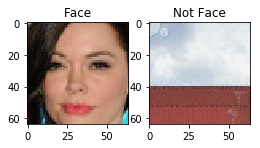

In [3]:
#@title Change the sliders to look at positive and negative training examples! { run: "auto" }

face_images = images[np.where(labels==1)[0]]
not_face_images = images[np.where(labels==0)[0]]

idx_face = 16 #@param {type:"slider", min:0, max:50, step:1}
idx_not_face = 42 #@param {type:"slider", min:0, max:50, step:1}

plt.figure(figsize=(4,2))
plt.subplot(1, 2, 1)
plt.imshow(face_images[idx_face])
plt.title("Face")
plt.grid(False)

plt.subplot(1, 2, 2)
plt.imshow(not_face_images[idx_not_face])
plt.title("Not Face")
plt.grid(False)

86253568/86241280 [==============================] - 4s 0us/step


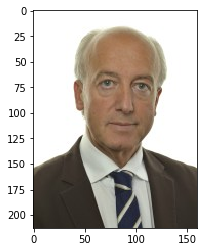

In [4]:
ppb = util.PPBFaceEvaluator(skip=4) # create the dataset handler

gender = "male" #@param ["male", "female"]
skin_color = "lighter" #@param ["lighter", "darker"]

img = ppb.get_sample_faces_from_demographic(gender, skin_color)
plt.imshow(img)
plt.grid(False)

## CNN

### Model Structure

In [6]:
n_outputs = 1 # number of outputs (i.e., face or not face)
n_filters = 12 # base number of convolutional filters

'''Function to define a standard CNN model'''
def make_standard_classifier():
    Conv2D = functools.partial(tf.keras.layers.Conv2D, padding='same', activation='relu')
    BatchNormalization = tf.keras.layers.BatchNormalization
    Flatten = tf.keras.layers.Flatten
    Dense = functools.partial(tf.keras.layers.Dense, activation='relu')

    model = tf.keras.Sequential([
    	# TODO: define a convolutional layer with n_filters 5x5 filters and 2x2 stride
        Conv2D(filters=n_filters, kernel_size=[5, 5], strides=[2, 2], input_shape=(64,64,3)),
        BatchNormalization(),
        
        # TODO: define a convolutional layer with 2*n_filters 5x5 filters and 2x2 stride
        Conv2D(filters=2*n_filters, kernel_size=[5, 5],  strides=[2, 2]),
        BatchNormalization(),

        # TODO: define a convolutional layer with 4*n_filters 3x3 filters and 2x2 stride
        Conv2D(filters=4*n_filters, kernel_size=[3, 3],  strides=[2, 2]),
        BatchNormalization(),

        # TODO: define a convolutional layer with 6*n_filters 3x3 filters and 1x1 stride
        Conv2D(filters=6*n_filters, kernel_size=[3, 3],  strides=[1, 1]),
        BatchNormalization(),

        Flatten(),
        Dense(1, activation=None),
        tf.keras.layers.Dropout(0.5)
    ])
    return model
  
standard_classifier = make_standard_classifier()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


### Training

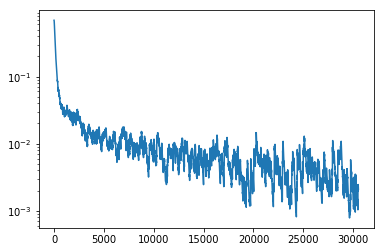

100%|######################################|Time:  0:02:07  Epoch: 9 Loss: 0.00


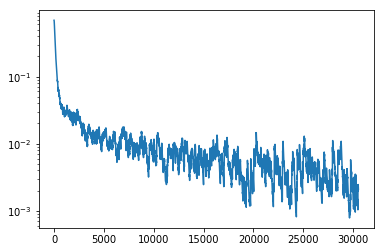

In [7]:
batch_size = 36
num_epochs = 10  # keep small to run faster
learning_rate = 1e-3

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate) # define our optimizer
loss_history = util.LossHistory(smoothing_factor=0.99) # to record the evolution of the loss
plotter = util.PeriodicPlotter(sec=2, scale='semilogy')

# The training loop!
for epoch in range(num_epochs):
  
  custom_msg = util.custom_progress_text("Epoch: %(epoch).0f Loss: %(loss)2.2f")
  bar = util.create_progress_bar(custom_msg)
  
  for idx in bar(range(loader.get_train_size()//batch_size)):
    # First grab a batch of training data and convert the input images to tensors
    x, y = loader.get_batch(batch_size)
    x = tf.convert_to_tensor(x, dtype=tf.float32)
    y = tf.convert_to_tensor(y, dtype=tf.float32)
    
    # GradientTape to record differentiation operations
    with tf.GradientTape() as tape:
      logits = standard_classifier(x) # feed the images into the model
      loss_value = tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=logits) # compute the loss

    custom_msg.update_mapping(epoch=epoch, loss=loss_value.numpy().mean())
    # Backpropagation
    grads = tape.gradient(loss_value, standard_classifier.variables)
    optimizer.apply_gradients(zip(grads, standard_classifier.variables), global_step=tf.train.get_or_create_global_step())

    loss_history.append(loss_value.numpy().mean()) 
    plotter.plot(loss_history.get())

### Evaluation

In [8]:
# Evaluate on a subset of CelebA+Imagenet
(batch_x, batch_y) = loader.get_batch(5000)
y_pred_standard = tf.round(tf.nn.sigmoid(standard_classifier.predict(batch_x)))
acc_standard = tf.reduce_mean(tf.cast(tf.equal(batch_y, y_pred_standard), tf.float32))
print "Standard CNN accuracy on (potentially biased) training set: {:.4f}".format(acc_standard.numpy())

Standard CNN accuracy on (potentially biased) training set: 0.9996


In [9]:
# Evaluate on PPB dataset (takes ~3 minutes)
standard_cnn_accuracy = []
for skin_color in ['lighter', 'darker']:
  for gender in ['male', 'female']:
    standard_cnn_accuracy.append( ppb.evaluate([standard_classifier], gender, skin_color, from_logit=True)[0] )
    print 
    print "{} {}: {}".format(gender, skin_color, standard_cnn_accuracy[-1])

100% (97 of 97) |########################| Elapsed Time: 0:01:18 Time:  0:01:18
N/A% (0 of 72) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--


male lighter: 0.907216494845


100% (72 of 72) |########################| Elapsed Time: 0:00:57 Time:  0:00:57
N/A% (0 of 78) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--


female lighter: 0.944444444444


100% (78 of 78) |########################| Elapsed Time: 0:00:58 Time:  0:00:58
N/A% (0 of 71) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--


male darker: 0.858974358974


100% (71 of 71) |########################| Elapsed Time: 0:00:55 Time:  0:00:55



female darker: 0.915492957746


Text(0,0.5,'Accuracy')

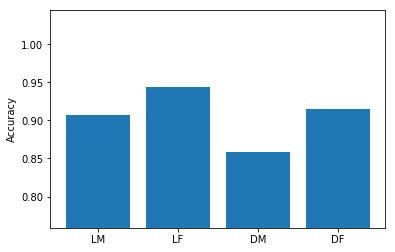

In [10]:
plt.bar(range(4), standard_cnn_accuracy)
plt.xticks(range(4), ('LM', 'LF', 'DM', 'DF'))
plt.ylim(np.min(standard_cnn_accuracy)-0.1,np.max(standard_cnn_accuracy)+0.1)
plt.ylabel('Accuracy')

**comments**
- All possible cases surpassed $80$% accuracy, which means that the model is relatively unbiased.
- Lighter Female achieves the best performance, which indicates that the dataset has a plenty of female white celebrities.

## Variational Autoencoder

### Loss Function

In [0]:
# Function to calculate VAE loss given an input x, reconstructed output x_pred, 
#    encoded means mu, encoded log of standard deviation logsigma, and weight parameter for the latent loss
def vae_loss_function(x, x_pred, mu, logsigma, kl_weight=0.0005):
  '''TODO: Define the latent loss'''
  latent_loss = 0.5 * tf.reduce_sum(tf.exp(logsigma) + tf.square(mu) - 1.0 - logsigma, axis=1)

  '''TODO: Define the reconstruction loss. Hint: you'll need to use tf.reduce_mean'''
  reconstruction_loss = tf.reduce_mean((x-x_pred)**2, axis=(1,2,3))

  '''TODO: Define the VAE loss'''
  vae_loss = kl_weight * latent_loss + reconstruction_loss

  return vae_loss

### Reparameterization

In [0]:
"""Reparameterization trick by sampling from an isotropic unit Gaussian.
# Arguments
    args (tensor): mean and log of standard deviation of latent distribution (Q(z|X))
# Returns
    z (tensor): sampled latent vector
"""
def sampling(args):
    z_mean, z_logsigma = args
    batch = z_mean.shape[0]
    dim = z_mean.shape[1]
    
    # by default, random_normal has mean=0 and std=1.0
    epsilon = tf.random_normal(tf.shape(z_mean))
    '''TODO: Define the reparameterization computation!'''
    return z_mean + tf.exp(0.5 * z_logsigma) * epsilon

## DB-VAE

### Loss Function

In [0]:
# Loss function for DB-VAE
def debiasing_loss_function(x, x_pred, y, y_logit, mu, logsigma):

  '''TODO: call the relevant function to obtain VAE loss'''
  vae_loss = vae_loss_function(x, x_pred, mu, logsigma)

  '''TODO: define the classification loss'''
  classification_loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=y_logit)
  
  # Use the training data labels to create variable face_mask
  face_mask = tf.cast(tf.equal(y, 1), tf.float32)
  
  '''TODO: define the DB-VAE total loss! Hint: think about the dimensionality of your output.'''
  total_loss = tf.reduce_mean(classification_loss + face_mask * vae_loss)
  
  return total_loss, classification_loss

### Encoder-Decoder Network

In [0]:
latent_dim = 100

#### Encoder

In [0]:
'''Define the encoder network for the DB-VAE'''
def make_face_encoder_network():
    Conv2D = functools.partial(tf.keras.layers.Conv2D, padding='same', activation='relu')
    BatchNormalization = tf.keras.layers.BatchNormalization
    Flatten = tf.keras.layers.Flatten
    Dense = functools.partial(tf.keras.layers.Dense, activation='relu')

    inputs = tf.keras.layers.Input(shape=(64,64,3))
    
    hidden = Conv2D(filters=1*n_filters, kernel_size=[5,5],  strides=[2,2])(inputs)
    hidden = BatchNormalization()(hidden)
    hidden = Conv2D(filters=2*n_filters, kernel_size=[5,5],  strides=[2,2])(hidden)
    hidden = BatchNormalization()(hidden)
    hidden = Conv2D(filters=4*n_filters, kernel_size=[3,3],  strides=[2,2])(hidden)
    hidden = BatchNormalization()(hidden)
    hidden = Conv2D(filters=6*n_filters, kernel_size=[3,3],  strides=[1,1])(hidden)
    hidden = BatchNormalization()(hidden)

    hidden = Flatten(name='flatten')(hidden)
    
    '''Encoder outputs:
        y_logit: supervised class prediction
        z_mean: means in the latent space
        z_logsigma: standard deviations in the latent space'''
    y_logit = Dense(1, activation=None, name='y_logit')(hidden)
    z_mean = Dense(latent_dim, name='z_mean')(hidden)
    z_logsigma = Dense(latent_dim, name='z_logsigma')(hidden)

    # use reparameterization trick to sample from the latent space
    z = tf.keras.layers.Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_logsigma])

    # define the outputs that the encoder model should return
    outputs = [y_logit, z_mean, z_logsigma, z]
    # finalize the encoder model
    encoder = tf.keras.Model(inputs=inputs, outputs=outputs, name='encoder')

    # get the shape of the final convolutional output (right before the flatten)
    flatten_layer_idx = encoder.layers.index(encoder.get_layer('flatten'))
    pre_flatten_shape = encoder.layers[flatten_layer_idx-1].get_output_at(0).shape[1:]
    
    return encoder, inputs, outputs, pre_flatten_shape

#### Decoder

In [0]:
'''Define the decoder network for the DB-VAE'''
def make_face_decoder_network(pre_flatten_shape):
  Conv2DTranspose = functools.partial(tf.keras.layers.Conv2DTranspose, padding='same', activation='relu')
  BatchNormalization = tf.keras.layers.BatchNormalization
  Flatten = tf.keras.layers.Flatten
  Dense = functools.partial(tf.keras.layers.Dense, activation='relu')

  latent_inputs = tf.keras.layers.Input(shape=(latent_dim,))
  
  hidden = Dense(tf.reduce_prod(pre_flatten_shape))(latent_inputs)
  hidden = tf.keras.layers.Reshape(pre_flatten_shape)(hidden)
  
  # series of deconvolutional layers with batch normalization
  hidden = Conv2DTranspose(filters=4*n_filters, kernel_size=[3,3],  strides=[1,1])(hidden)
  hidden = BatchNormalization()(hidden)
  hidden = Conv2DTranspose(filters=2*n_filters, kernel_size=[3,3],  strides=[2,2])(hidden)
  hidden = BatchNormalization()(hidden)
  hidden = Conv2DTranspose(filters=1*n_filters, kernel_size=[5,5],  strides=[2,2])(hidden)
  hidden = BatchNormalization()(hidden)
  
  x_hat = Conv2DTranspose(filters=3, kernel_size=[5,5], strides=[2,2])(hidden)

  # instantiate decoder model
  decoder = tf.keras.Model(inputs=latent_inputs, outputs=x_hat, name='decoder')
  return decoder

#### Structure

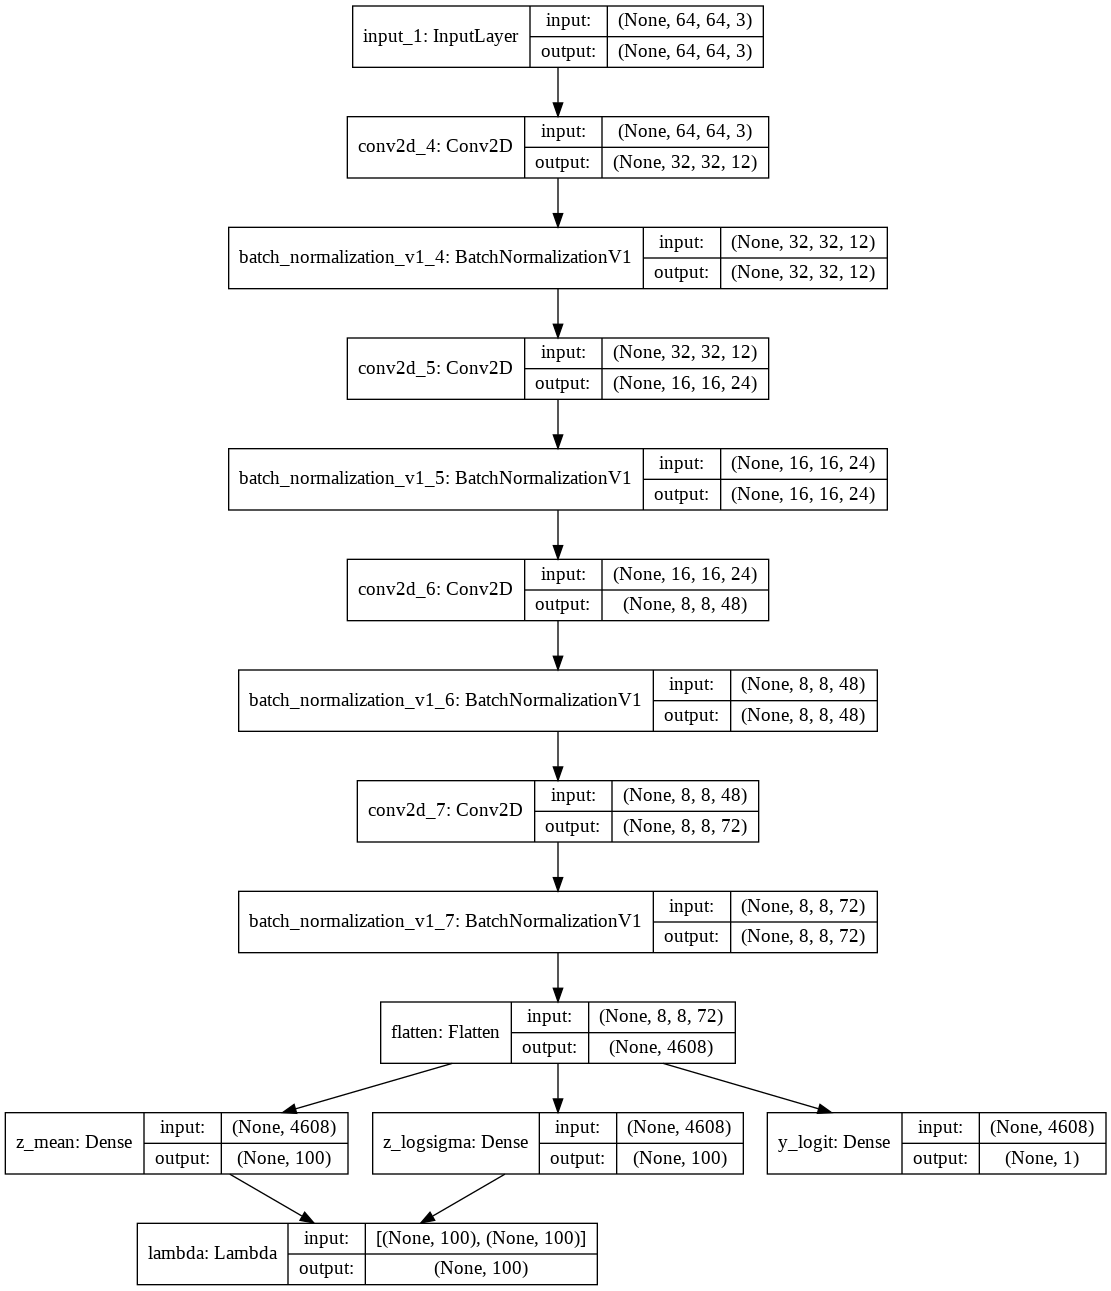

In [18]:
'''TODO: create the encoder and decoder networks'''
encoder, inputs, ouputs, pre_flatten_shape = make_face_encoder_network()
decoder = make_face_decoder_network(pre_flatten_shape)

# initialize the models
encoder_output = encoder(inputs)
y_logit, z_mean, z_logsigma, z = encoder_output
reconstructed_inputs = decoder(z)

vae = tf.keras.Model(inputs, reconstructed_inputs)
util.display_model(encoder)

### Adaptive Resampling

In [0]:
# Function to return the means for an input image batch
def get_latent_mu(images, encoder, batch_size=1024):
    N = images.shape[0]
    mu = np.zeros((N, latent_dim))
    for start_ind in xrange(0, N, batch_size):
        end_ind = min(start_ind+batch_size, N+1)
        batch = images[start_ind:end_ind]
        batch = tf.convert_to_tensor(batch, dtype=tf.float32)/255.
        _, batch_mu, _, _ = encoder(batch)
        mu[start_ind:end_ind] = batch_mu
    return mu

### Training

In [0]:
'''Function that recomputes the sampling probabilities for images within a batch
    based on how they distribute across the '''
def get_training_sample_probabilities(images, encoder, bins=10, smoothing_fac=0.0): 
    print "Recomputing the sampling probabilities"
    
    mu = get_latent_mu(images, encoder)
    # sampling probabilities for the images
    training_sample_p = np.zeros(mu.shape[0])
    
    # consider the distribution for each latent variable 
    for i in range(latent_dim):
      
        latent_distribution = mu[:,i]
        # generate a histogram of the latent distribution
        hist_density, bin_edges =  np.histogram(latent_distribution, density=True, bins=bins)

        # find which latent bin every data sample falls in 
        # https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.digitize.html
        bin_edges[0] = -float('inf')
        bin_edges[-1] = float('inf')
        '''TODO: call the digitize function to find which bins in the latent distribution 
            every data sample falls in to'''
        bin_idx = np.digitize(latent_distribution, bin_edges)

        # smooth the density function [Eq. #]
        hist_smoothed_density = hist_density + smoothing_fac
        hist_smoothed_density = hist_smoothed_density / np.sum(hist_smoothed_density)

        '''TODO: invert the density function to compute the sampling probability!
            HINT: think carefully about the indexing of the bins! What is the length of bin_edges?'''
        p = 1.0/(hist_smoothed_density[bin_idx-1])
        
        # normalize all probabilities
        p = p / np.sum(p)
        
        # update sampling probabilities 
        training_sample_p = np.maximum(p, training_sample_p)
        
    # final normalization
    training_sample_p /= np.sum(training_sample_p)

    return training_sample_p

Recomputing the sampling probabilities


N/A%|     |ETA:  --:--:--  Epoch: nan   Iter: nan   Class Loss: nan   Loss: nan

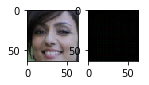

  3%|      |ETA:   0:03:14  Epoch: 0   Iter: 99   Class Loss: 0.10   Loss: 0.14

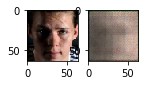

  6%|     |ETA:   0:03:26  Epoch: 0   Iter: 199   Class Loss: 0.07   Loss: 0.11

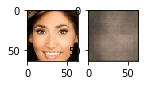

  9%|     |ETA:   0:03:02  Epoch: 0   Iter: 298   Class Loss: 0.11   Loss: 0.14

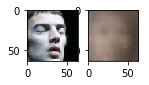

 13%|     |ETA:   0:02:54  Epoch: 0   Iter: 398   Class Loss: 0.10   Loss: 0.13

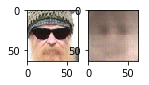

 16%|     |ETA:   0:02:45  Epoch: 0   Iter: 499   Class Loss: 0.18   Loss: 0.21

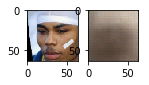

 19%|     |ETA:   0:02:43  Epoch: 0   Iter: 599   Class Loss: 0.02   Loss: 0.05

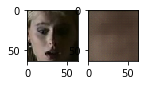

 22%|#    |ETA:   0:02:37  Epoch: 0   Iter: 699   Class Loss: 0.07   Loss: 0.10

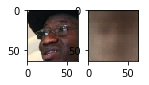

 26%|#    |ETA:   0:02:29  Epoch: 0   Iter: 798   Class Loss: 0.03   Loss: 0.06

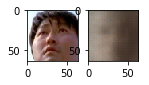

 29%|#    |ETA:   0:02:23  Epoch: 0   Iter: 898   Class Loss: 0.01   Loss: 0.03

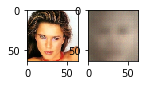

 32%|#    |ETA:   0:02:14  Epoch: 0   Iter: 998   Class Loss: 0.01   Loss: 0.03

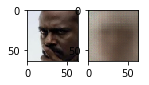

 35%|#   |ETA:   0:02:08  Epoch: 0   Iter: 1098   Class Loss: 0.03   Loss: 0.06

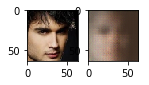

 39%|#   |ETA:   0:02:03  Epoch: 0   Iter: 1198   Class Loss: 0.02   Loss: 0.05

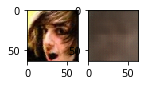

 42%|#   |ETA:   0:01:53  Epoch: 0   Iter: 1299   Class Loss: 0.09   Loss: 0.12

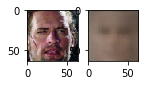

 45%|#   |ETA:   0:01:49  Epoch: 0   Iter: 1399   Class Loss: 0.02   Loss: 0.04

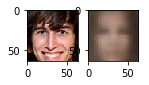

 49%|#   |ETA:   0:01:42  Epoch: 0   Iter: 1498   Class Loss: 0.00   Loss: 0.03

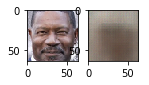

 52%|##  |ETA:   0:01:35  Epoch: 0   Iter: 1598   Class Loss: 0.00   Loss: 0.03

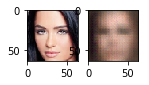

 55%|##  |ETA:   0:01:29  Epoch: 0   Iter: 1699   Class Loss: 0.02   Loss: 0.05

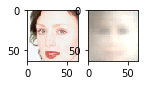

 58%|##  |ETA:   0:01:22  Epoch: 0   Iter: 1799   Class Loss: 0.01   Loss: 0.03

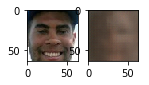

 62%|##  |ETA:   0:01:16  Epoch: 0   Iter: 1899   Class Loss: 0.00   Loss: 0.04

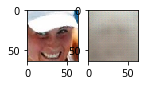

 65%|##  |ETA:   0:01:10  Epoch: 0   Iter: 1998   Class Loss: 0.00   Loss: 0.03

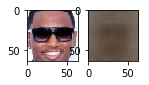

 68%|##  |ETA:   0:01:03  Epoch: 0   Iter: 2098   Class Loss: 0.14   Loss: 0.16

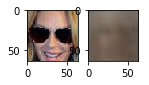

 72%|##  |ETA:   0:00:57  Epoch: 0   Iter: 2198   Class Loss: 0.00   Loss: 0.03

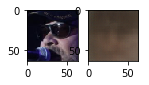

 75%|### |ETA:   0:00:49  Epoch: 0   Iter: 2298   Class Loss: 0.00   Loss: 0.03

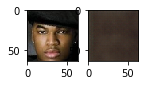

 78%|### |ETA:   0:00:43  Epoch: 0   Iter: 2398   Class Loss: 0.00   Loss: 0.03

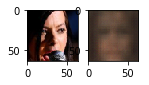

 81%|### |ETA:   0:00:39  Epoch: 0   Iter: 2499   Class Loss: 0.00   Loss: 0.04

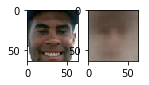

 85%|### |ETA:   0:00:32  Epoch: 0   Iter: 2599   Class Loss: 0.00   Loss: 0.03

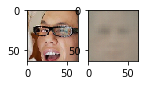

 88%|### |ETA:   0:00:23  Epoch: 0   Iter: 2698   Class Loss: 0.00   Loss: 0.03

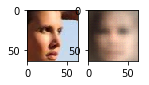

 91%|### |ETA:   0:00:16  Epoch: 0   Iter: 2798   Class Loss: 0.01   Loss: 0.04

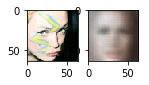

 94%|### |ETA:   0:00:10  Epoch: 0   Iter: 2898   Class Loss: 0.01   Loss: 0.03

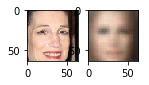

 98%|### |ETA:   0:00:03  Epoch: 0   Iter: 2999   Class Loss: 0.00   Loss: 0.03

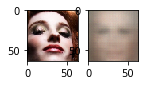

100%|####|Time:  0:03:29  Epoch: 0   Iter: 3052   Class Loss: 0.02   Loss: 0.05


Recomputing the sampling probabilities


N/A%|     |ETA:  --:--:--  Epoch: nan   Iter: nan   Class Loss: nan   Loss: nan

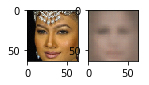

  3%|      |ETA:   0:03:16  Epoch: 1   Iter: 99   Class Loss: 0.00   Loss: 0.02

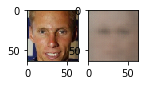

  6%|     |ETA:   0:03:08  Epoch: 1   Iter: 199   Class Loss: 0.00   Loss: 0.02

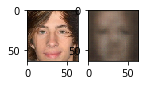

  9%|     |ETA:   0:03:02  Epoch: 1   Iter: 298   Class Loss: 0.00   Loss: 0.03

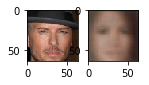

 13%|     |ETA:   0:02:55  Epoch: 1   Iter: 398   Class Loss: 0.00   Loss: 0.03

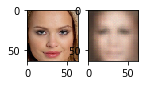

 16%|     |ETA:   0:02:49  Epoch: 1   Iter: 499   Class Loss: 0.00   Loss: 0.02

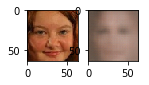

 19%|     |ETA:   0:02:43  Epoch: 1   Iter: 599   Class Loss: 0.00   Loss: 0.03

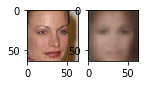

 22%|#    |ETA:   0:02:35  Epoch: 1   Iter: 699   Class Loss: 0.02   Loss: 0.04

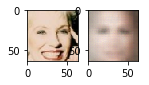

 26%|#    |ETA:   0:02:29  Epoch: 1   Iter: 798   Class Loss: 0.00   Loss: 0.02

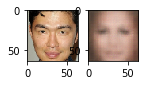

 29%|#    |ETA:   0:02:24  Epoch: 1   Iter: 898   Class Loss: 0.00   Loss: 0.03

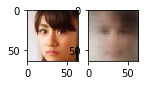

 32%|#    |ETA:   0:02:17  Epoch: 1   Iter: 998   Class Loss: 0.00   Loss: 0.02

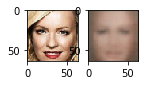

 35%|#   |ETA:   0:02:09  Epoch: 1   Iter: 1098   Class Loss: 0.00   Loss: 0.03

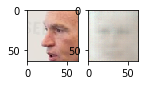

 39%|#   |ETA:   0:02:03  Epoch: 1   Iter: 1198   Class Loss: 0.00   Loss: 0.02

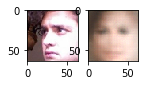

 42%|#   |ETA:   0:01:57  Epoch: 1   Iter: 1299   Class Loss: 0.02   Loss: 0.05

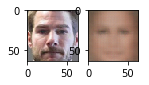

 45%|#   |ETA:   0:01:51  Epoch: 1   Iter: 1399   Class Loss: 0.00   Loss: 0.03

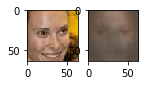

 49%|#   |ETA:   0:01:49  Epoch: 1   Iter: 1498   Class Loss: 0.00   Loss: 0.02

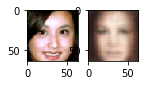

 52%|##  |ETA:   0:01:36  Epoch: 1   Iter: 1598   Class Loss: 0.00   Loss: 0.03

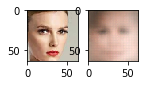

 55%|##  |ETA:   0:01:31  Epoch: 1   Iter: 1699   Class Loss: 0.00   Loss: 0.03

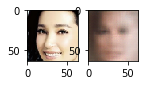

 58%|##  |ETA:   0:01:24  Epoch: 1   Iter: 1799   Class Loss: 0.00   Loss: 0.03

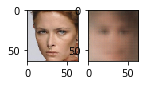

 62%|##  |ETA:   0:01:17  Epoch: 1   Iter: 1899   Class Loss: 0.02   Loss: 0.04

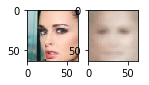

 65%|##  |ETA:   0:01:10  Epoch: 1   Iter: 1998   Class Loss: 0.00   Loss: 0.02

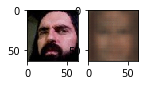

 68%|##  |ETA:   0:01:02  Epoch: 1   Iter: 2098   Class Loss: 0.00   Loss: 0.03

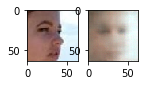

 72%|##  |ETA:   0:00:56  Epoch: 1   Iter: 2198   Class Loss: 0.00   Loss: 0.03

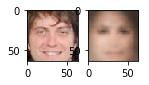

 75%|### |ETA:   0:00:50  Epoch: 1   Iter: 2298   Class Loss: 0.00   Loss: 0.03

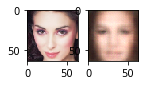

 78%|### |ETA:   0:00:43  Epoch: 1   Iter: 2398   Class Loss: 0.00   Loss: 0.03

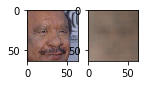

 81%|### |ETA:   0:00:36  Epoch: 1   Iter: 2499   Class Loss: 0.00   Loss: 0.02

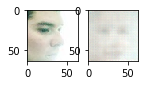

 85%|### |ETA:   0:00:30  Epoch: 1   Iter: 2599   Class Loss: 0.00   Loss: 0.02

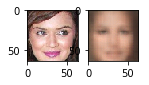

 88%|### |ETA:   0:00:23  Epoch: 1   Iter: 2698   Class Loss: 0.00   Loss: 0.02

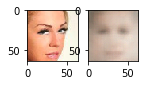

 91%|### |ETA:   0:00:16  Epoch: 1   Iter: 2798   Class Loss: 0.00   Loss: 0.02

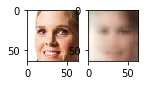

 94%|### |ETA:   0:00:10  Epoch: 1   Iter: 2898   Class Loss: 0.01   Loss: 0.04

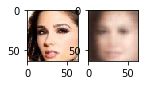

 98%|### |ETA:   0:00:03  Epoch: 1   Iter: 2999   Class Loss: 0.00   Loss: 0.02

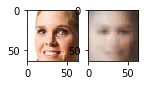

100%|####|Time:  0:03:30  Epoch: 1   Iter: 3052   Class Loss: 0.00   Loss: 0.02


Recomputing the sampling probabilities


N/A%|     |ETA:  --:--:--  Epoch: nan   Iter: nan   Class Loss: nan   Loss: nan

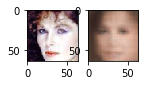

  3%|      |ETA:   0:03:16  Epoch: 2   Iter: 99   Class Loss: 0.00   Loss: 0.03

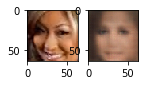

  6%|     |ETA:   0:03:10  Epoch: 2   Iter: 199   Class Loss: 0.00   Loss: 0.02

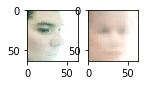

  9%|     |ETA:   0:03:00  Epoch: 2   Iter: 298   Class Loss: 0.00   Loss: 0.03

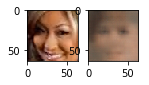

 13%|     |ETA:   0:02:58  Epoch: 2   Iter: 398   Class Loss: 0.00   Loss: 0.03

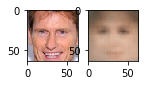

 16%|     |ETA:   0:02:48  Epoch: 2   Iter: 499   Class Loss: 0.00   Loss: 0.03

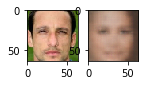

 19%|     |ETA:   0:02:43  Epoch: 2   Iter: 599   Class Loss: 0.00   Loss: 0.02

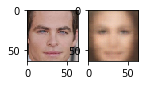

 22%|#    |ETA:   0:02:36  Epoch: 2   Iter: 699   Class Loss: 0.00   Loss: 0.03

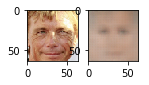

 26%|#    |ETA:   0:02:39  Epoch: 2   Iter: 798   Class Loss: 0.00   Loss: 0.02

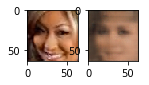

 29%|#    |ETA:   0:02:34  Epoch: 2   Iter: 898   Class Loss: 0.00   Loss: 0.03

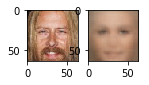

 32%|#    |ETA:   0:02:16  Epoch: 2   Iter: 998   Class Loss: 0.00   Loss: 0.02

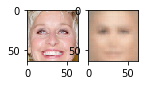

 35%|#   |ETA:   0:02:10  Epoch: 2   Iter: 1098   Class Loss: 0.00   Loss: 0.03

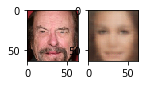

 39%|#   |ETA:   0:02:02  Epoch: 2   Iter: 1198   Class Loss: 0.00   Loss: 0.03

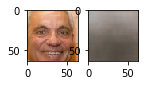

 42%|#   |ETA:   0:01:57  Epoch: 2   Iter: 1299   Class Loss: 0.00   Loss: 0.02

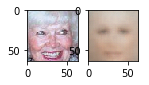

 45%|#   |ETA:   0:01:49  Epoch: 2   Iter: 1399   Class Loss: 0.00   Loss: 0.02

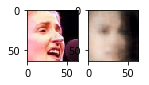

 49%|#   |ETA:   0:01:41  Epoch: 2   Iter: 1498   Class Loss: 0.00   Loss: 0.03

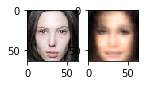

 52%|##  |ETA:   0:01:37  Epoch: 2   Iter: 1598   Class Loss: 0.00   Loss: 0.03

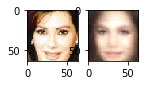

 55%|##  |ETA:   0:01:30  Epoch: 2   Iter: 1699   Class Loss: 0.27   Loss: 0.29

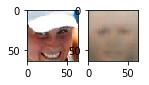

 58%|##  |ETA:   0:01:23  Epoch: 2   Iter: 1799   Class Loss: 0.00   Loss: 0.02

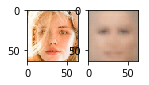

 62%|##  |ETA:   0:01:17  Epoch: 2   Iter: 1899   Class Loss: 0.00   Loss: 0.02

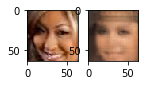

 65%|##  |ETA:   0:01:09  Epoch: 2   Iter: 1998   Class Loss: 0.00   Loss: 0.03

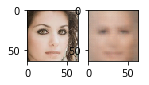

 68%|##  |ETA:   0:01:02  Epoch: 2   Iter: 2098   Class Loss: 0.01   Loss: 0.03

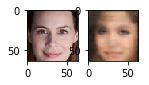

 72%|##  |ETA:   0:00:56  Epoch: 2   Iter: 2198   Class Loss: 0.00   Loss: 0.02

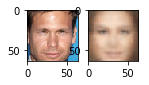

 75%|### |ETA:   0:00:51  Epoch: 2   Iter: 2298   Class Loss: 0.00   Loss: 0.03

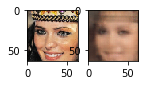

 78%|### |ETA:   0:00:43  Epoch: 2   Iter: 2398   Class Loss: 0.03   Loss: 0.06

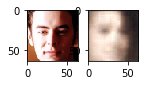

 81%|### |ETA:   0:00:37  Epoch: 2   Iter: 2499   Class Loss: 0.00   Loss: 0.03

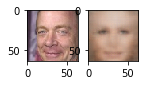

 85%|### |ETA:   0:00:30  Epoch: 2   Iter: 2599   Class Loss: 0.00   Loss: 0.02

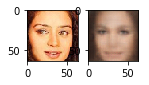

 88%|### |ETA:   0:00:23  Epoch: 2   Iter: 2698   Class Loss: 0.00   Loss: 0.02

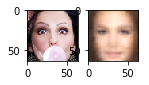

 91%|### |ETA:   0:00:17  Epoch: 2   Iter: 2798   Class Loss: 0.00   Loss: 0.03

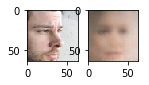

 94%|### |ETA:   0:00:11  Epoch: 2   Iter: 2898   Class Loss: 0.00   Loss: 0.02

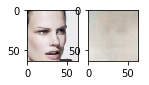

 98%|### |ETA:   0:00:03  Epoch: 2   Iter: 2999   Class Loss: 0.00   Loss: 0.03

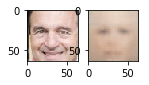

100%|####|Time:  0:03:30  Epoch: 2   Iter: 3052   Class Loss: 0.00   Loss: 0.02


Recomputing the sampling probabilities


N/A%|     |ETA:  --:--:--  Epoch: nan   Iter: nan   Class Loss: nan   Loss: nan

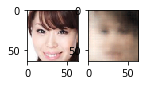

  3%|      |ETA:   0:03:14  Epoch: 3   Iter: 99   Class Loss: 0.00   Loss: 0.02

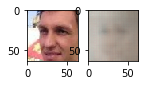

  6%|     |ETA:   0:03:10  Epoch: 3   Iter: 199   Class Loss: 0.00   Loss: 0.02

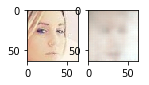

  9%|     |ETA:   0:03:04  Epoch: 3   Iter: 298   Class Loss: 0.00   Loss: 0.03

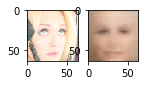

 13%|     |ETA:   0:02:55  Epoch: 3   Iter: 398   Class Loss: 0.00   Loss: 0.03

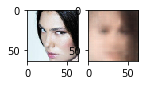

 16%|     |ETA:   0:02:49  Epoch: 3   Iter: 499   Class Loss: 0.00   Loss: 0.03

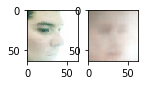

 19%|     |ETA:   0:02:42  Epoch: 3   Iter: 599   Class Loss: 0.01   Loss: 0.04

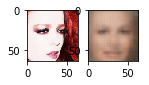

 22%|#    |ETA:   0:02:38  Epoch: 3   Iter: 699   Class Loss: 0.00   Loss: 0.02

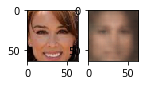

 26%|#    |ETA:   0:02:32  Epoch: 3   Iter: 798   Class Loss: 0.04   Loss: 0.06

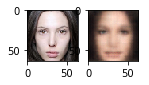

 29%|#    |ETA:   0:02:25  Epoch: 3   Iter: 898   Class Loss: 0.00   Loss: 0.02

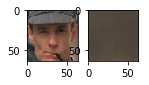

 32%|#    |ETA:   0:02:19  Epoch: 3   Iter: 998   Class Loss: 0.00   Loss: 0.03

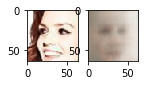

 35%|#   |ETA:   0:02:13  Epoch: 3   Iter: 1098   Class Loss: 0.00   Loss: 0.02

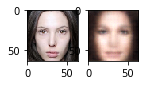

 39%|#   |ETA:   0:02:03  Epoch: 3   Iter: 1198   Class Loss: 0.00   Loss: 0.03

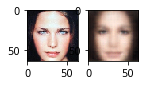

 42%|#   |ETA:   0:01:58  Epoch: 3   Iter: 1299   Class Loss: 0.00   Loss: 0.02

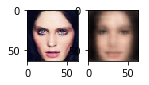

 45%|#   |ETA:   0:01:50  Epoch: 3   Iter: 1399   Class Loss: 0.00   Loss: 0.02

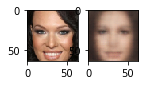

 49%|#   |ETA:   0:01:42  Epoch: 3   Iter: 1498   Class Loss: 0.00   Loss: 0.02

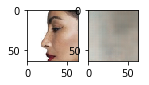

 52%|##  |ETA:   0:01:36  Epoch: 3   Iter: 1598   Class Loss: 0.00   Loss: 0.03

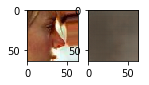

 55%|##  |ETA:   0:01:29  Epoch: 3   Iter: 1699   Class Loss: 0.00   Loss: 0.03

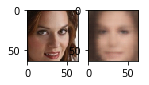

 58%|##  |ETA:   0:01:23  Epoch: 3   Iter: 1799   Class Loss: 0.00   Loss: 0.03

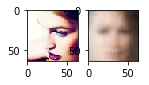

 62%|##  |ETA:   0:01:16  Epoch: 3   Iter: 1899   Class Loss: 0.00   Loss: 0.03

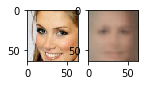

 65%|##  |ETA:   0:01:11  Epoch: 3   Iter: 1998   Class Loss: 0.00   Loss: 0.02

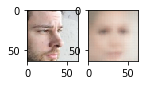

 68%|##  |ETA:   0:01:03  Epoch: 3   Iter: 2098   Class Loss: 0.00   Loss: 0.03

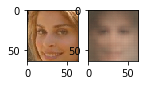

 72%|##  |ETA:   0:01:02  Epoch: 3   Iter: 2198   Class Loss: 0.00   Loss: 0.02

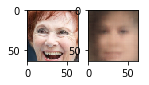

 75%|### |ETA:   0:00:52  Epoch: 3   Iter: 2298   Class Loss: 0.00   Loss: 0.02

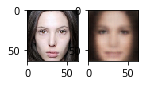

 78%|### |ETA:   0:00:43  Epoch: 3   Iter: 2398   Class Loss: 0.00   Loss: 0.02

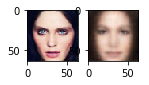

 81%|### |ETA:   0:00:37  Epoch: 3   Iter: 2499   Class Loss: 0.00   Loss: 0.03

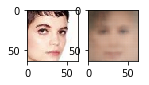

 85%|### |ETA:   0:00:30  Epoch: 3   Iter: 2599   Class Loss: 0.00   Loss: 0.03

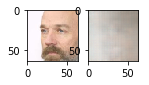

 88%|### |ETA:   0:00:23  Epoch: 3   Iter: 2698   Class Loss: 0.00   Loss: 0.02

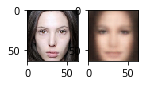

 91%|### |ETA:   0:00:17  Epoch: 3   Iter: 2798   Class Loss: 0.00   Loss: 0.03

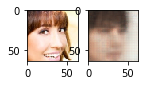

 94%|### |ETA:   0:00:10  Epoch: 3   Iter: 2898   Class Loss: 0.00   Loss: 0.02

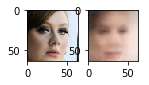

 98%|### |ETA:   0:00:03  Epoch: 3   Iter: 2999   Class Loss: 0.00   Loss: 0.02

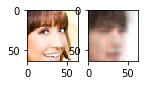

100%|####|Time:  0:03:30  Epoch: 3   Iter: 3052   Class Loss: 0.00   Loss: 0.03


Recomputing the sampling probabilities


N/A%|     |ETA:  --:--:--  Epoch: nan   Iter: nan   Class Loss: nan   Loss: nan

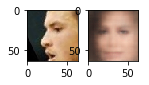

  3%|      |ETA:   0:03:16  Epoch: 4   Iter: 99   Class Loss: 0.00   Loss: 0.02

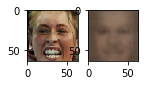

  6%|     |ETA:   0:03:08  Epoch: 4   Iter: 199   Class Loss: 0.00   Loss: 0.02

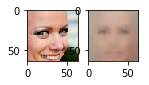

  9%|     |ETA:   0:03:01  Epoch: 4   Iter: 298   Class Loss: 0.01   Loss: 0.03

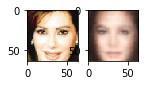

 13%|     |ETA:   0:02:56  Epoch: 4   Iter: 398   Class Loss: 0.06   Loss: 0.08

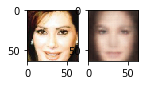

 16%|     |ETA:   0:02:50  Epoch: 4   Iter: 499   Class Loss: 0.00   Loss: 0.02

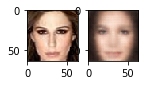

 19%|     |ETA:   0:02:43  Epoch: 4   Iter: 599   Class Loss: 0.00   Loss: 0.03

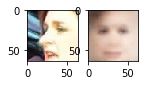

 22%|#    |ETA:   0:02:36  Epoch: 4   Iter: 699   Class Loss: 0.00   Loss: 0.03

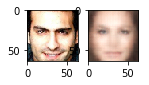

 26%|#    |ETA:   0:02:29  Epoch: 4   Iter: 798   Class Loss: 0.00   Loss: 0.03

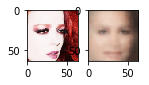

 29%|#    |ETA:   0:02:22  Epoch: 4   Iter: 898   Class Loss: 0.00   Loss: 0.03

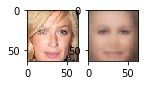

 32%|#    |ETA:   0:02:14  Epoch: 4   Iter: 998   Class Loss: 0.00   Loss: 0.03

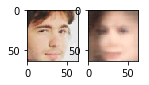

 35%|#   |ETA:   0:02:22  Epoch: 4   Iter: 1098   Class Loss: 0.00   Loss: 0.02

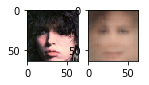

 39%|#   |ETA:   0:02:01  Epoch: 4   Iter: 1198   Class Loss: 0.00   Loss: 0.02

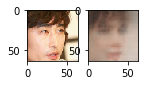

 42%|#   |ETA:   0:01:54  Epoch: 4   Iter: 1299   Class Loss: 0.00   Loss: 0.02

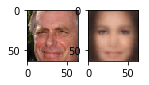

 45%|#   |ETA:   0:01:49  Epoch: 4   Iter: 1399   Class Loss: 0.00   Loss: 0.03

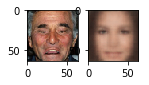

 49%|#   |ETA:   0:01:43  Epoch: 4   Iter: 1498   Class Loss: 0.00   Loss: 0.03

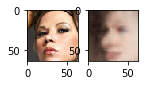

 52%|##  |ETA:   0:01:36  Epoch: 4   Iter: 1598   Class Loss: 0.00   Loss: 0.02

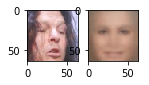

 55%|##  |ETA:   0:01:29  Epoch: 4   Iter: 1699   Class Loss: 0.00   Loss: 0.03

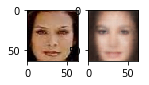

 58%|##  |ETA:   0:01:23  Epoch: 4   Iter: 1799   Class Loss: 0.00   Loss: 0.03

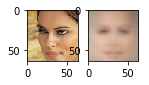

 62%|##  |ETA:   0:01:16  Epoch: 4   Iter: 1899   Class Loss: 0.00   Loss: 0.03

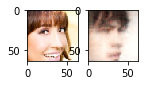

 65%|##  |ETA:   0:01:10  Epoch: 4   Iter: 1998   Class Loss: 0.00   Loss: 0.02

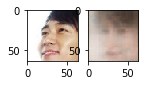

 68%|##  |ETA:   0:01:01  Epoch: 4   Iter: 2098   Class Loss: 0.00   Loss: 0.03

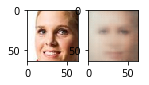

 72%|##  |ETA:   0:00:55  Epoch: 4   Iter: 2198   Class Loss: 0.00   Loss: 0.03

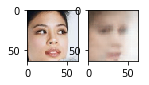

 75%|### |ETA:   0:00:50  Epoch: 4   Iter: 2298   Class Loss: 0.00   Loss: 0.02

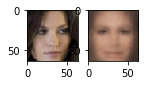

 78%|### |ETA:   0:00:42  Epoch: 4   Iter: 2398   Class Loss: 0.00   Loss: 0.03

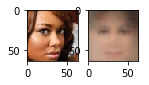

 81%|### |ETA:   0:00:36  Epoch: 4   Iter: 2499   Class Loss: 0.00   Loss: 0.02

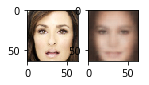

 85%|### |ETA:   0:00:30  Epoch: 4   Iter: 2599   Class Loss: 0.00   Loss: 0.02

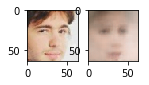

 88%|### |ETA:   0:00:23  Epoch: 4   Iter: 2698   Class Loss: 0.00   Loss: 0.03

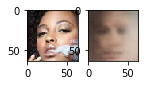

 91%|### |ETA:   0:00:16  Epoch: 4   Iter: 2798   Class Loss: 0.00   Loss: 0.03

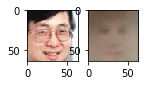

 94%|### |ETA:   0:00:10  Epoch: 4   Iter: 2898   Class Loss: 0.00   Loss: 0.02

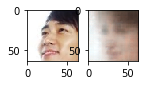

 98%|### |ETA:   0:00:03  Epoch: 4   Iter: 2999   Class Loss: 0.04   Loss: 0.07

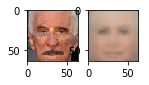

100%|####|Time:  0:03:28  Epoch: 4   Iter: 3052   Class Loss: 0.00   Loss: 0.03


Recomputing the sampling probabilities


N/A%|     |ETA:  --:--:--  Epoch: nan   Iter: nan   Class Loss: nan   Loss: nan

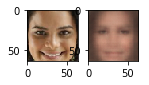

  3%|      |ETA:   0:03:10  Epoch: 5   Iter: 99   Class Loss: 0.00   Loss: 0.02

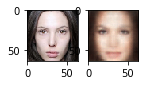

  6%|     |ETA:   0:03:09  Epoch: 5   Iter: 199   Class Loss: 0.00   Loss: 0.02

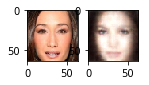

  9%|     |ETA:   0:02:59  Epoch: 5   Iter: 298   Class Loss: 0.00   Loss: 0.02

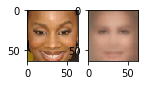

 13%|     |ETA:   0:02:53  Epoch: 5   Iter: 398   Class Loss: 0.00   Loss: 0.02

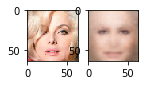

 16%|     |ETA:   0:02:49  Epoch: 5   Iter: 499   Class Loss: 0.00   Loss: 0.02

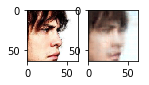

 19%|     |ETA:   0:02:56  Epoch: 5   Iter: 599   Class Loss: 0.00   Loss: 0.02

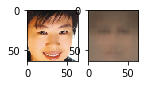

 22%|#    |ETA:   0:02:34  Epoch: 5   Iter: 699   Class Loss: 0.00   Loss: 0.02

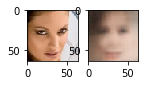

 26%|#    |ETA:   0:02:30  Epoch: 5   Iter: 798   Class Loss: 0.00   Loss: 0.02

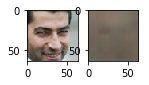

 29%|#    |ETA:   0:02:22  Epoch: 5   Iter: 898   Class Loss: 0.00   Loss: 0.02

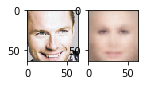

 32%|#    |ETA:   0:02:15  Epoch: 5   Iter: 998   Class Loss: 0.00   Loss: 0.02

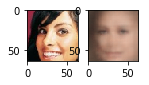

 35%|#   |ETA:   0:02:11  Epoch: 5   Iter: 1098   Class Loss: 0.00   Loss: 0.02

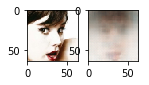

 39%|#   |ETA:   0:02:03  Epoch: 5   Iter: 1198   Class Loss: 0.00   Loss: 0.03

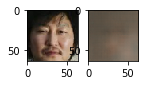

 42%|#   |ETA:   0:01:56  Epoch: 5   Iter: 1299   Class Loss: 0.00   Loss: 0.03

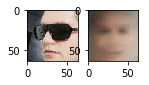

 45%|#   |ETA:   0:01:48  Epoch: 5   Iter: 1399   Class Loss: 0.00   Loss: 0.02

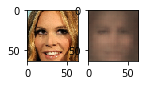

 49%|#   |ETA:   0:01:42  Epoch: 5   Iter: 1498   Class Loss: 0.00   Loss: 0.02

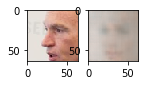

 52%|##  |ETA:   0:01:36  Epoch: 5   Iter: 1598   Class Loss: 0.00   Loss: 0.02

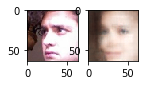

 55%|##  |ETA:   0:01:29  Epoch: 5   Iter: 1699   Class Loss: 0.00   Loss: 0.03

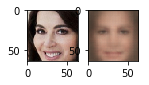

 58%|##  |ETA:   0:01:21  Epoch: 5   Iter: 1799   Class Loss: 0.00   Loss: 0.02

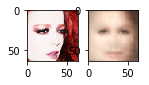

 62%|##  |ETA:   0:01:16  Epoch: 5   Iter: 1899   Class Loss: 0.00   Loss: 0.03

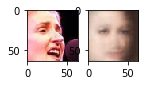

 65%|##  |ETA:   0:01:09  Epoch: 5   Iter: 1998   Class Loss: 0.00   Loss: 0.03

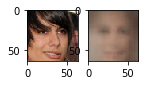

 68%|##  |ETA:   0:01:04  Epoch: 5   Iter: 2098   Class Loss: 0.00   Loss: 0.03

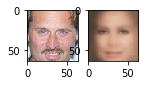

 72%|##  |ETA:   0:00:57  Epoch: 5   Iter: 2198   Class Loss: 0.00   Loss: 0.03

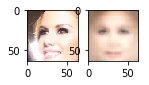

 75%|### |ETA:   0:00:50  Epoch: 5   Iter: 2298   Class Loss: 0.00   Loss: 0.03

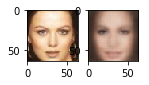

 78%|### |ETA:   0:00:42  Epoch: 5   Iter: 2398   Class Loss: 0.00   Loss: 0.03

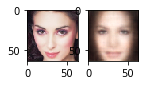

 81%|### |ETA:   0:00:40  Epoch: 5   Iter: 2499   Class Loss: 0.00   Loss: 0.03

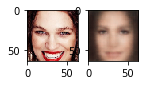

 85%|### |ETA:   0:00:30  Epoch: 5   Iter: 2599   Class Loss: 0.00   Loss: 0.02

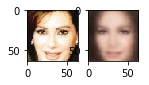

 88%|### |ETA:   0:00:23  Epoch: 5   Iter: 2698   Class Loss: 0.00   Loss: 0.02

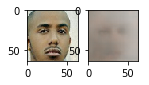

 91%|### |ETA:   0:00:16  Epoch: 5   Iter: 2798   Class Loss: 0.00   Loss: 0.02

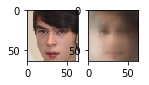

 94%|### |ETA:   0:00:10  Epoch: 5   Iter: 2898   Class Loss: 0.00   Loss: 0.02

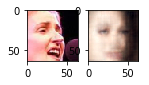

 98%|### |ETA:   0:00:03  Epoch: 5   Iter: 2999   Class Loss: 0.25   Loss: 0.27

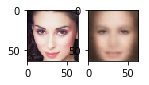

100%|####|Time:  0:03:28  Epoch: 5   Iter: 3052   Class Loss: 0.00   Loss: 0.03


Recomputing the sampling probabilities


N/A%|     |ETA:  --:--:--  Epoch: nan   Iter: nan   Class Loss: nan   Loss: nan

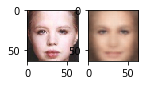

  3%|      |ETA:   0:03:17  Epoch: 6   Iter: 99   Class Loss: 0.00   Loss: 0.02

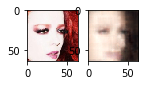

  6%|     |ETA:   0:03:09  Epoch: 6   Iter: 199   Class Loss: 0.00   Loss: 0.02

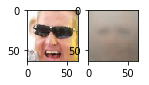

  9%|     |ETA:   0:03:07  Epoch: 6   Iter: 298   Class Loss: 0.00   Loss: 0.03

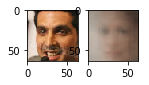

 13%|     |ETA:   0:02:55  Epoch: 6   Iter: 398   Class Loss: 0.00   Loss: 0.02

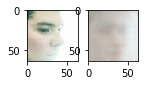

 16%|     |ETA:   0:02:44  Epoch: 6   Iter: 499   Class Loss: 0.00   Loss: 0.03

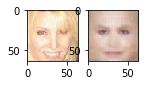

 19%|     |ETA:   0:02:39  Epoch: 6   Iter: 599   Class Loss: 0.00   Loss: 0.02

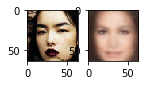

 22%|#    |ETA:   0:02:35  Epoch: 6   Iter: 699   Class Loss: 0.00   Loss: 0.02

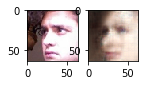

 26%|#    |ETA:   0:02:30  Epoch: 6   Iter: 798   Class Loss: 0.00   Loss: 0.03

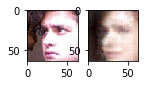

 29%|#    |ETA:   0:02:23  Epoch: 6   Iter: 898   Class Loss: 0.00   Loss: 0.02

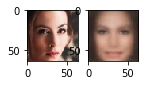

 32%|#    |ETA:   0:02:16  Epoch: 6   Iter: 998   Class Loss: 0.00   Loss: 0.03

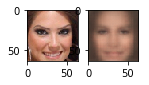

 35%|#   |ETA:   0:02:08  Epoch: 6   Iter: 1098   Class Loss: 0.00   Loss: 0.02

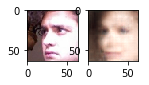

 39%|#   |ETA:   0:02:03  Epoch: 6   Iter: 1198   Class Loss: 0.00   Loss: 0.02

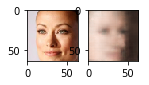

 42%|#   |ETA:   0:01:56  Epoch: 6   Iter: 1299   Class Loss: 0.00   Loss: 0.02

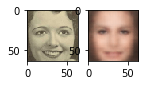

 45%|#   |ETA:   0:01:46  Epoch: 6   Iter: 1399   Class Loss: 0.00   Loss: 0.03

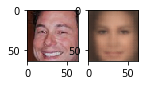

 49%|#   |ETA:   0:01:40  Epoch: 6   Iter: 1498   Class Loss: 0.00   Loss: 0.02

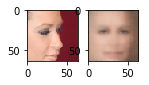

 52%|##  |ETA:   0:01:35  Epoch: 6   Iter: 1598   Class Loss: 0.00   Loss: 0.02

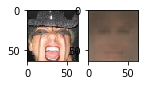

 55%|##  |ETA:   0:01:28  Epoch: 6   Iter: 1699   Class Loss: 0.00   Loss: 0.02

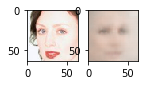

 58%|##  |ETA:   0:01:23  Epoch: 6   Iter: 1799   Class Loss: 0.00   Loss: 0.03

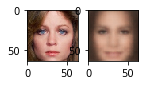

 62%|##  |ETA:   0:01:16  Epoch: 6   Iter: 1899   Class Loss: 0.00   Loss: 0.03

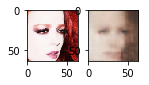

 65%|##  |ETA:   0:01:14  Epoch: 6   Iter: 1998   Class Loss: 0.00   Loss: 0.02

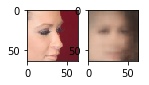

 68%|##  |ETA:   0:01:05  Epoch: 6   Iter: 2098   Class Loss: 0.00   Loss: 0.02

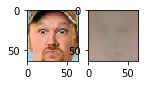

 72%|##  |ETA:   0:00:55  Epoch: 6   Iter: 2198   Class Loss: 0.00   Loss: 0.03

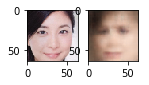

 75%|### |ETA:   0:00:48  Epoch: 6   Iter: 2298   Class Loss: 0.00   Loss: 0.02

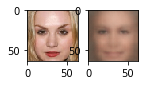

 78%|### |ETA:   0:00:42  Epoch: 6   Iter: 2398   Class Loss: 0.00   Loss: 0.02

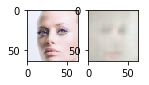

 81%|### |ETA:   0:00:35  Epoch: 6   Iter: 2499   Class Loss: 0.00   Loss: 0.02

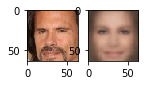

 85%|### |ETA:   0:00:29  Epoch: 6   Iter: 2599   Class Loss: 0.00   Loss: 0.02

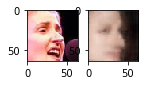

 88%|### |ETA:   0:00:22  Epoch: 6   Iter: 2698   Class Loss: 0.00   Loss: 0.03

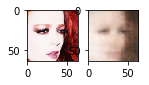

 91%|### |ETA:   0:00:16  Epoch: 6   Iter: 2798   Class Loss: 0.00   Loss: 0.02

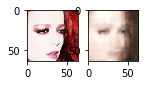

 94%|### |ETA:   0:00:10  Epoch: 6   Iter: 2898   Class Loss: 0.00   Loss: 0.02

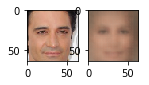

 98%|### |ETA:   0:00:03  Epoch: 6   Iter: 2999   Class Loss: 0.00   Loss: 0.02

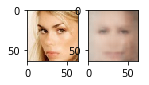

100%|####|Time:  0:03:27  Epoch: 6   Iter: 3052   Class Loss: 0.00   Loss: 0.03


Recomputing the sampling probabilities


N/A%|     |ETA:  --:--:--  Epoch: nan   Iter: nan   Class Loss: nan   Loss: nan

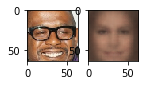

  3%|      |ETA:   0:03:13  Epoch: 7   Iter: 99   Class Loss: 0.00   Loss: 0.03

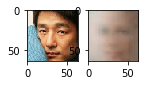

  6%|     |ETA:   0:03:10  Epoch: 7   Iter: 199   Class Loss: 0.00   Loss: 0.02

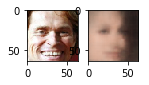

  9%|     |ETA:   0:03:01  Epoch: 7   Iter: 298   Class Loss: 0.00   Loss: 0.03

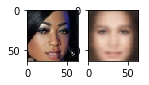

 13%|     |ETA:   0:02:54  Epoch: 7   Iter: 398   Class Loss: 0.00   Loss: 0.02

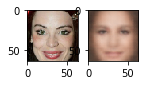

 16%|     |ETA:   0:02:49  Epoch: 7   Iter: 499   Class Loss: 0.04   Loss: 0.06

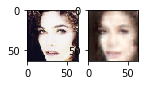

 19%|     |ETA:   0:02:42  Epoch: 7   Iter: 599   Class Loss: 0.00   Loss: 0.02

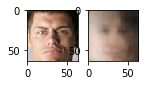

 22%|#    |ETA:   0:02:37  Epoch: 7   Iter: 699   Class Loss: 0.00   Loss: 0.02

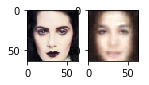

 26%|#    |ETA:   0:02:40  Epoch: 7   Iter: 798   Class Loss: 0.00   Loss: 0.03

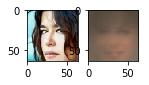

 29%|#    |ETA:   0:02:22  Epoch: 7   Iter: 898   Class Loss: 0.00   Loss: 0.03

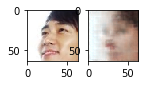

 32%|#    |ETA:   0:02:15  Epoch: 7   Iter: 998   Class Loss: 0.00   Loss: 0.02

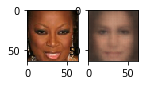

 35%|#   |ETA:   0:02:08  Epoch: 7   Iter: 1098   Class Loss: 0.00   Loss: 0.02

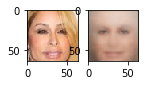

 39%|#   |ETA:   0:02:03  Epoch: 7   Iter: 1198   Class Loss: 0.00   Loss: 0.02

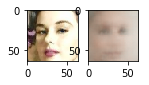

 42%|#   |ETA:   0:01:55  Epoch: 7   Iter: 1299   Class Loss: 0.00   Loss: 0.02

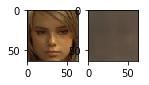

 45%|#   |ETA:   0:01:48  Epoch: 7   Iter: 1399   Class Loss: 0.00   Loss: 0.02

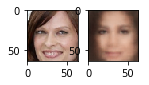

 49%|#   |ETA:   0:01:42  Epoch: 7   Iter: 1498   Class Loss: 0.00   Loss: 0.03

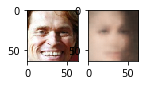

 52%|##  |ETA:   0:01:36  Epoch: 7   Iter: 1598   Class Loss: 0.00   Loss: 0.03

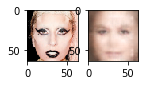

 55%|##  |ETA:   0:01:29  Epoch: 7   Iter: 1699   Class Loss: 0.00   Loss: 0.02

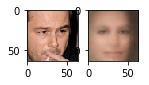

 58%|##  |ETA:   0:01:22  Epoch: 7   Iter: 1799   Class Loss: 0.00   Loss: 0.03

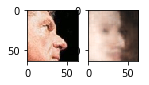

 62%|##  |ETA:   0:01:15  Epoch: 7   Iter: 1899   Class Loss: 0.00   Loss: 0.03

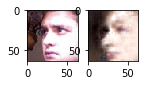

 65%|##  |ETA:   0:01:10  Epoch: 7   Iter: 1998   Class Loss: 0.00   Loss: 0.02

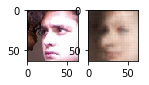

 68%|##  |ETA:   0:01:03  Epoch: 7   Iter: 2098   Class Loss: 0.00   Loss: 0.03

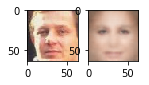

 72%|##  |ETA:   0:00:56  Epoch: 7   Iter: 2198   Class Loss: 0.00   Loss: 0.02

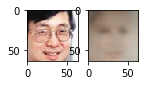

 75%|### |ETA:   0:00:49  Epoch: 7   Iter: 2298   Class Loss: 0.00   Loss: 0.03

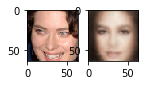

 78%|### |ETA:   0:00:43  Epoch: 7   Iter: 2398   Class Loss: 0.00   Loss: 0.02

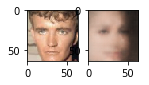

 81%|### |ETA:   0:00:36  Epoch: 7   Iter: 2499   Class Loss: 0.00   Loss: 0.02

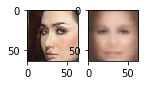

 85%|### |ETA:   0:00:29  Epoch: 7   Iter: 2599   Class Loss: 0.00   Loss: 0.02

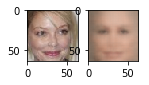

 88%|### |ETA:   0:00:23  Epoch: 7   Iter: 2698   Class Loss: 0.00   Loss: 0.03

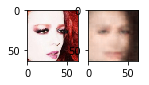

 91%|### |ETA:   0:00:16  Epoch: 7   Iter: 2798   Class Loss: 0.00   Loss: 0.02

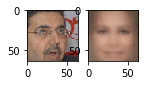

 94%|### |ETA:   0:00:10  Epoch: 7   Iter: 2898   Class Loss: 0.00   Loss: 0.02

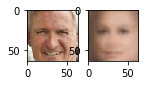

 98%|### |ETA:   0:00:03  Epoch: 7   Iter: 2999   Class Loss: 0.00   Loss: 0.02

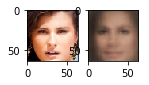

100%|####|Time:  0:03:28  Epoch: 7   Iter: 3052   Class Loss: 0.00   Loss: 0.03


Recomputing the sampling probabilities


N/A%|     |ETA:  --:--:--  Epoch: nan   Iter: nan   Class Loss: nan   Loss: nan

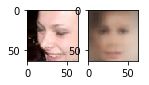

  3%|      |ETA:   0:03:15  Epoch: 8   Iter: 99   Class Loss: 0.00   Loss: 0.02

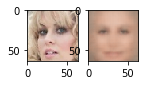

  6%|     |ETA:   0:03:08  Epoch: 8   Iter: 199   Class Loss: 0.00   Loss: 0.03

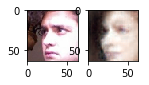

  9%|     |ETA:   0:03:02  Epoch: 8   Iter: 298   Class Loss: 0.00   Loss: 0.02

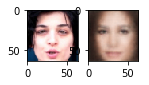

 13%|     |ETA:   0:03:05  Epoch: 8   Iter: 398   Class Loss: 0.00   Loss: 0.03

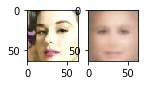

 16%|     |ETA:   0:02:50  Epoch: 8   Iter: 499   Class Loss: 0.00   Loss: 0.03

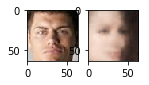

 19%|     |ETA:   0:02:41  Epoch: 8   Iter: 599   Class Loss: 0.01   Loss: 0.03

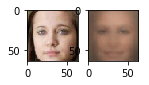

 22%|#    |ETA:   0:02:35  Epoch: 8   Iter: 699   Class Loss: 0.00   Loss: 0.02

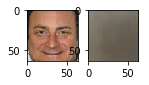

 26%|#    |ETA:   0:02:28  Epoch: 8   Iter: 798   Class Loss: 0.00   Loss: 0.02

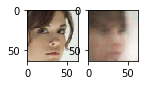

 29%|#    |ETA:   0:02:24  Epoch: 8   Iter: 898   Class Loss: 0.12   Loss: 0.15

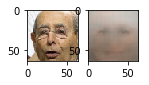

 32%|#    |ETA:   0:02:17  Epoch: 8   Iter: 998   Class Loss: 0.00   Loss: 0.02

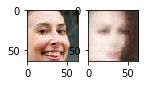

 35%|#   |ETA:   0:02:10  Epoch: 8   Iter: 1098   Class Loss: 0.00   Loss: 0.03

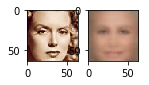

 39%|#   |ETA:   0:02:01  Epoch: 8   Iter: 1198   Class Loss: 0.00   Loss: 0.03

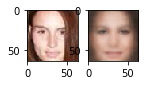

 42%|#   |ETA:   0:01:55  Epoch: 8   Iter: 1299   Class Loss: 0.00   Loss: 0.02

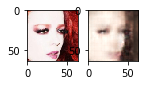

 45%|#   |ETA:   0:01:50  Epoch: 8   Iter: 1399   Class Loss: 0.00   Loss: 0.02

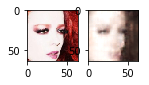

 49%|#   |ETA:   0:01:42  Epoch: 8   Iter: 1498   Class Loss: 0.00   Loss: 0.02

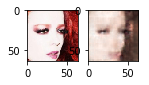

 52%|##  |ETA:   0:01:37  Epoch: 8   Iter: 1598   Class Loss: 0.00   Loss: 0.03

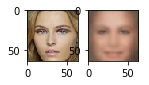

 55%|##  |ETA:   0:01:30  Epoch: 8   Iter: 1699   Class Loss: 0.00   Loss: 0.02

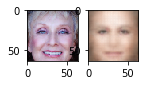

 58%|##  |ETA:   0:01:23  Epoch: 8   Iter: 1799   Class Loss: 0.00   Loss: 0.02

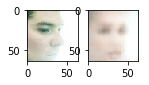

 62%|##  |ETA:   0:01:16  Epoch: 8   Iter: 1899   Class Loss: 0.00   Loss: 0.02

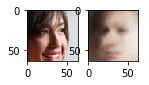

 65%|##  |ETA:   0:01:08  Epoch: 8   Iter: 1998   Class Loss: 0.00   Loss: 0.02

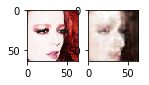

 68%|##  |ETA:   0:01:04  Epoch: 8   Iter: 2098   Class Loss: 0.00   Loss: 0.02

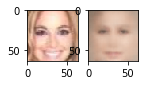

 72%|##  |ETA:   0:00:56  Epoch: 8   Iter: 2198   Class Loss: 0.00   Loss: 0.02

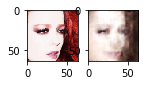

 75%|### |ETA:   0:00:48  Epoch: 8   Iter: 2298   Class Loss: 0.00   Loss: 0.03

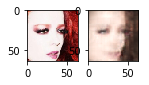

 78%|### |ETA:   0:00:43  Epoch: 8   Iter: 2398   Class Loss: 0.00   Loss: 0.02

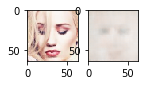

 81%|### |ETA:   0:00:37  Epoch: 8   Iter: 2499   Class Loss: 0.00   Loss: 0.02

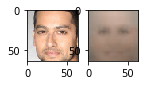

 85%|### |ETA:   0:00:29  Epoch: 8   Iter: 2599   Class Loss: 0.04   Loss: 0.06

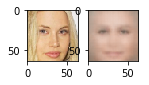

 88%|### |ETA:   0:00:23  Epoch: 8   Iter: 2698   Class Loss: 0.01   Loss: 0.03

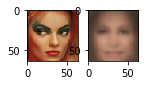

 91%|### |ETA:   0:00:16  Epoch: 8   Iter: 2798   Class Loss: 0.00   Loss: 0.02

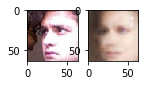

 94%|### |ETA:   0:00:10  Epoch: 8   Iter: 2898   Class Loss: 0.00   Loss: 0.02

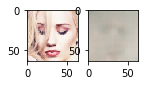

 98%|### |ETA:   0:00:03  Epoch: 8   Iter: 2999   Class Loss: 0.00   Loss: 0.02

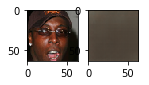

100%|####|Time:  0:03:29  Epoch: 8   Iter: 3052   Class Loss: 0.00   Loss: 0.02


Recomputing the sampling probabilities


N/A%|     |ETA:  --:--:--  Epoch: nan   Iter: nan   Class Loss: nan   Loss: nan

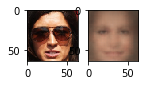

  3%|      |ETA:   0:03:13  Epoch: 9   Iter: 99   Class Loss: 0.00   Loss: 0.02

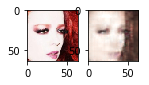

  6%|     |ETA:   0:03:07  Epoch: 9   Iter: 199   Class Loss: 0.00   Loss: 0.02

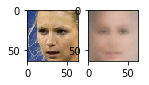

  9%|     |ETA:   0:02:58  Epoch: 9   Iter: 298   Class Loss: 0.00   Loss: 0.02

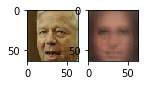

 13%|     |ETA:   0:02:53  Epoch: 9   Iter: 398   Class Loss: 0.00   Loss: 0.02

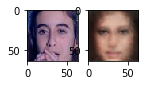

 16%|     |ETA:   0:02:44  Epoch: 9   Iter: 499   Class Loss: 0.01   Loss: 0.03

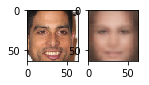

 19%|     |ETA:   0:02:38  Epoch: 9   Iter: 599   Class Loss: 0.00   Loss: 0.02

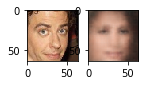

 22%|#    |ETA:   0:02:37  Epoch: 9   Iter: 699   Class Loss: 0.00   Loss: 0.02

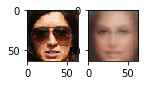

 26%|#    |ETA:   0:02:29  Epoch: 9   Iter: 798   Class Loss: 0.00   Loss: 0.03

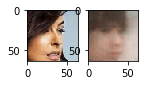

 29%|#    |ETA:   0:02:20  Epoch: 9   Iter: 898   Class Loss: 0.00   Loss: 0.02

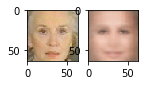

 32%|#    |ETA:   0:02:13  Epoch: 9   Iter: 998   Class Loss: 0.00   Loss: 0.02

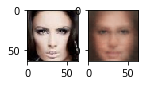

 35%|#   |ETA:   0:02:09  Epoch: 9   Iter: 1098   Class Loss: 0.00   Loss: 0.02

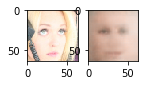

 39%|#   |ETA:   0:02:01  Epoch: 9   Iter: 1198   Class Loss: 0.00   Loss: 0.02

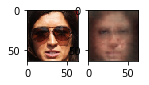

 42%|#   |ETA:   0:01:55  Epoch: 9   Iter: 1299   Class Loss: 0.00   Loss: 0.02

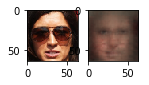

 45%|#   |ETA:   0:01:48  Epoch: 9   Iter: 1399   Class Loss: 0.00   Loss: 0.02

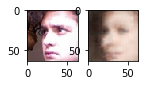

 49%|#   |ETA:   0:01:44  Epoch: 9   Iter: 1498   Class Loss: 0.00   Loss: 0.02

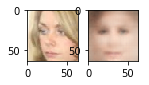

 52%|##  |ETA:   0:01:34  Epoch: 9   Iter: 1598   Class Loss: 0.00   Loss: 0.03

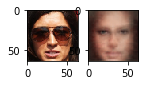

 55%|##  |ETA:   0:01:29  Epoch: 9   Iter: 1699   Class Loss: 0.00   Loss: 0.02

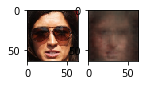

 58%|##  |ETA:   0:01:30  Epoch: 9   Iter: 1799   Class Loss: 0.00   Loss: 0.02

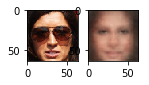

 62%|##  |ETA:   0:01:21  Epoch: 9   Iter: 1899   Class Loss: 0.00   Loss: 0.02

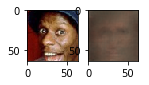

 65%|##  |ETA:   0:01:08  Epoch: 9   Iter: 1998   Class Loss: 0.00   Loss: 0.03

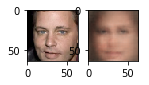

 68%|##  |ETA:   0:01:03  Epoch: 9   Iter: 2098   Class Loss: 0.00   Loss: 0.02

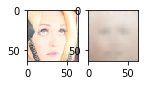

 72%|##  |ETA:   0:00:56  Epoch: 9   Iter: 2198   Class Loss: 0.00   Loss: 0.02

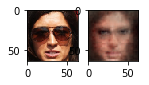

 75%|### |ETA:   0:00:49  Epoch: 9   Iter: 2298   Class Loss: 0.00   Loss: 0.03

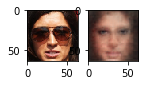

 78%|### |ETA:   0:00:42  Epoch: 9   Iter: 2398   Class Loss: 0.00   Loss: 0.02

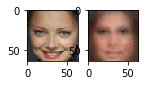

 81%|### |ETA:   0:00:36  Epoch: 9   Iter: 2499   Class Loss: 0.00   Loss: 0.02

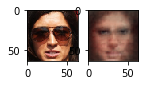

 85%|### |ETA:   0:00:30  Epoch: 9   Iter: 2599   Class Loss: 0.00   Loss: 0.02

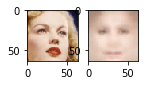

 88%|### |ETA:   0:00:23  Epoch: 9   Iter: 2698   Class Loss: 0.00   Loss: 0.03

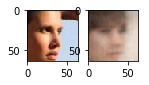

 91%|### |ETA:   0:00:16  Epoch: 9   Iter: 2798   Class Loss: 0.00   Loss: 0.02

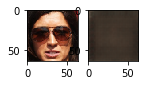

 94%|### |ETA:   0:00:10  Epoch: 9   Iter: 2898   Class Loss: 0.00   Loss: 0.02

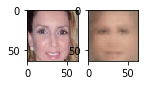

 98%|### |ETA:   0:00:03  Epoch: 9   Iter: 2999   Class Loss: 0.00   Loss: 0.02

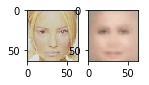

100%|####|Time:  0:03:27  Epoch: 9   Iter: 3052   Class Loss: 0.00   Loss: 0.03


In [21]:
loss_history = []
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)

enable_debiasing = True
all_faces = loader.get_all_train_faces() # parameter from data loader

for epoch in range(num_epochs):
  
  # progress message and bar
  custom_msg = util.custom_progress_text("Epoch: %(epoch).0f   Iter: %(idx).0f   Class Loss: %(class_loss)2.2f   Loss: %(loss)2.2f")
  bar = util.create_progress_bar(custom_msg)

  p_faces = None
  if enable_debiasing: 
      # Recompute data sampling proabilities if debiasing is enabled
      '''TODO: write the function call to recompute the sampling probabilities
          when debiasing is enabled'''
      p_faces = get_training_sample_probabilities(all_faces, encoder)
  
  for idx in bar(range(loader.get_train_size()//batch_size)):
    # load a batch of data
    (x, y) = loader.get_batch(batch_size, p_pos=p_faces)
    x = tf.convert_to_tensor(x, dtype=tf.float32)
    y = tf.convert_to_tensor(y, dtype=tf.float32)
  
    # define GradientTape for automatic differentiation
    with tf.GradientTape() as tape:
      y_logit, mu, logsigma, z = encoder(x)
      x_hat = decoder(z)
      '''TODO: call the relevant loss function to compute the loss'''
      loss, class_loss = debiasing_loss_function(x, x_hat, y, y_logit, mu, logsigma)
    
    '''TODO: use the GradientTape.gradient method to compute the gradients'''
    grads = tape.gradient(loss, vae.variables)

    # apply gradients to variables
    optimizer.apply_gradients(zip(grads, vae.variables),
                              global_step=tf.train.get_or_create_global_step())

    # track the losses
    class_loss_value = class_loss.numpy().mean()
    loss_value = loss.numpy().mean()
    loss_history.append((class_loss_value, loss_value))
    custom_msg.update_mapping(epoch=epoch, idx=idx, loss=loss_value, class_loss=class_loss_value)
    
    # plot the progress every 100 steps
    if idx%100 == 0: 
      util.plot_sample(x,y,vae)

### Evaluation

In [22]:
# Evaluate on PPB dataset (takes ~4 minutes)
accuracy_debiased = []
for skin_color in ['lighter', 'darker']:
  for gender in ['male', 'female']:
    accuracy_debiased.append( ppb.evaluate([encoder], gender, skin_color, output_idx=0, from_logit=True)[0] )
    print 
    print "{} {}: {}".format(gender, skin_color, accuracy_debiased[-1])

100% (97 of 97) |########################| Elapsed Time: 0:01:18 Time:  0:01:18
N/A% (0 of 72) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--


male lighter: 0.896907216495


100% (72 of 72) |########################| Elapsed Time: 0:00:57 Time:  0:00:57
N/A% (0 of 78) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--


female lighter: 0.833333333333


100% (78 of 78) |########################| Elapsed Time: 0:00:58 Time:  0:00:58
N/A% (0 of 71) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--


male darker: 0.782051282051


100% (71 of 71) |########################| Elapsed Time: 0:00:54 Time:  0:00:54



female darker: 0.87323943662


Text(0,0.5,'Accuracy')

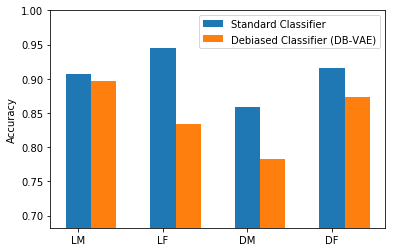

In [23]:
bar_width = 0.3
plt.bar(np.arange(4), standard_cnn_accuracy, width=bar_width)
plt.bar(np.arange(4)+bar_width, accuracy_debiased, width=bar_width)
plt.legend(('Standard Classifier','Debiased Classifier (DB-VAE)'))
plt.xticks(np.arange(4), ('LM', 'LF', 'DM', 'DF'))
plt.ylim(np.min([standard_cnn_accuracy,accuracy_debiased])-0.1,1)
plt.ylabel('Accuracy')
